# Convolutional neural networks

In [1]:
import pickle
import numpy as np
import keras
import matplotlib.pyplot as plt
import math


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7721859361815364141
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3368157184
locality {
  bus_id: 1
}
incarnation: 4254569675750717167
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, Adamax, Adagrad,RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
import numpy as np
import scipy

In [6]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 60

## Improving AlexNet

In [7]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [8]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [9]:
# print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

## Augmentation. optimizer: Adagrad()

In [10]:
data_augmentation = True
optimizer=Adagrad()

In [11]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

### Train the Model

In [12]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    
    def step_decay(epoch):
        initial_lrate = 0.1
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lrate

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[LearningRateScheduler(step_decay)],
                    workers=4)


Using real-time data augmentation.
Epoch 1/60
 - 28s - loss: 5.1138 - acc: 0.2541 - val_loss: 2.4952 - val_acc: 0.2084
Epoch 2/60
 - 26s - loss: 2.1910 - acc: 0.3824 - val_loss: 2.1129 - val_acc: 0.3323
Epoch 3/60
 - 26s - loss: 2.0745 - acc: 0.4155 - val_loss: 2.5392 - val_acc: 0.2810
Epoch 4/60
 - 26s - loss: 1.8631 - acc: 0.4487 - val_loss: 1.7795 - val_acc: 0.4732
Epoch 5/60
 - 26s - loss: 1.7359 - acc: 0.4757 - val_loss: 1.6013 - val_acc: 0.5264
Epoch 6/60
 - 26s - loss: 1.6469 - acc: 0.5013 - val_loss: 1.5320 - val_acc: 0.5297
Epoch 7/60
 - 26s - loss: 1.5572 - acc: 0.5245 - val_loss: 1.5182 - val_acc: 0.5417
Epoch 8/60
 - 26s - loss: 1.4978 - acc: 0.5404 - val_loss: 1.4345 - val_acc: 0.5676
Epoch 9/60
 - 26s - loss: 1.4481 - acc: 0.5572 - val_loss: 1.3470 - val_acc: 0.5959
Epoch 10/60
 - 26s - loss: 1.3648 - acc: 0.5851 - val_loss: 1.2690 - val_acc: 0.6212
Epoch 11/60
 - 26s - loss: 1.3268 - acc: 0.5976 - val_loss: 1.1761 - val_acc: 0.6565
Epoch 12/60
 - 26s - loss: 1.3018 - acc

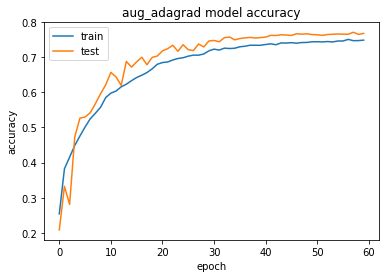

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('aug_adagrad model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

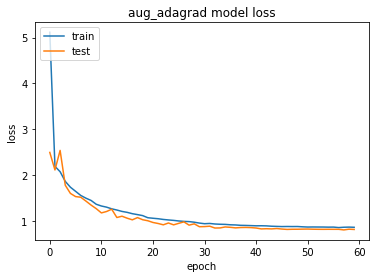

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('aug_adagrad model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test the model

In [15]:
aug_adagrad_score = model.evaluate(x_test, y_test, verbose=0)

In [16]:
print('cv loss:', aug_adagrad_score[0])

cv loss: 0.8152190686225891


In [17]:
print('cv accuracy:', aug_adagrad_score[1])

cv accuracy: 0.7675
